# Welcome to the Pruning Workshop!

In this workshop, we'll learn the concept of Pruning Neural Network models using Pytorch. We'll do the following tasks:
1. **Dataset** — Download and use FashionMNIST dataset
2. **Network** — Define a custom neural net and measure the metrics
3. **Training** — Train the model on the dataset, and record the accuracy metrics
4. **Pruning** — Apply different Pruning techniques on the model
5. **Analysis** — Visualize the results and find the best!

### Basic Imports

In [11]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from typing import Any, List
import pandas as pd
from tqdm import tqdm

# DL library imports
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn, optim
import torch.nn.functional as F

In [12]:
# DATA_PATH = '/home/slabban/machine_learning_courses/datasets/think_autonomous/neural_optimization'
# url = 'https://optimization-thinkautonomous.s3.eu-west-3.amazonaws.com/pruning.zip'
# if os.path.isdir(DATA_PATH):
#     if not os.listdir(DATA_PATH):
#         os.chdir(DATA_PATH)
#         !wget https://optimization-thinkautonomous.s3.eu-west-3.amazonaws.com/pruning.zip && \
#          unzip -q pruning.zip && \
#          rm pruning.zip 
#     else: 
#         print("Data Exists")
# else:
#     print("Given directory doesn't exist")

## 1 — **Dataset**: Download and use the Fashion MNIST Dataset


Here, we're going to use the FashionMNIST dataset for this case study.
- Fashion MNIST dataset is Zalando's collection of grayscale images of different apparels and their associated labels for Deep Learning research and development
- It consists of 60k train images and 10k test images, each of resolution 28 X 28 pixels
- The images contain integer values in range [0-255] and there are 10 labels. eg : 0 = T-shirt/top, 1 = Trouser, 2 = Pullover, 3 = Dress etc
- [Zalando FashionMNIST git repo](https://github.com/zalandoresearch/fashion-mnist)

In [13]:
dataset_labels = ['TShirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'AnkleBoot']

# necessary image transform i.e. convert to Tensor, normalize
train_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)) ])
test_transform  = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)) ])

# Download the Train and Test set
train_set = datasets.FashionMNIST('.', train=True, download=True, transform=train_transform)
test_set = datasets.FashionMNIST('.', train=False, download=True, transform=test_transform)

### Define HyperParameters

In [14]:
NUM_WORKERS = 1 
TEST_BATCH_SIZE  = 64
TRAIN_BATCH_SIZE = 16
VALID_SIZE = 0.2 

### Train/Test Split

In [15]:
len_train_set = len(train_set)
index_list = list(range(len_train_set))
np.random.shuffle(index_list)
split_index = int(len_train_set * VALID_SIZE)
train_idx, valid_idx = index_list[split_index:], index_list[:split_index]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

### DataLoader

In [16]:
train_loader = DataLoader(train_set, batch_size=TRAIN_BATCH_SIZE, sampler=train_sampler, num_workers=NUM_WORKERS)
valid_loader = DataLoader(train_set, batch_size=TEST_BATCH_SIZE,  sampler=valid_sampler, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_set,  batch_size=TEST_BATCH_SIZE,  shuffle=True,num_workers=NUM_WORKERS)

### Visualization

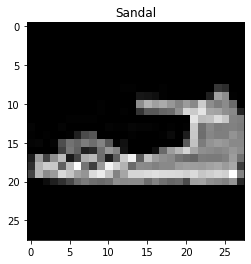

In [17]:
img, label = next(iter(train_loader))
plt.imshow(img[0].numpy().squeeze(), cmap = 'Greys_r')
plt.title(f'{dataset_labels[label[0].item()]}')
plt.show()

## 2 — **Network**: Define a custom neural net and measure the metrics

- We'll use a simple feed forward model that takes in flattened image vector (28x28=784) and outputs probabilities for each of 10 classes.
- In Pytorch, we can create the Neural Network model by defining a custom class (inherits from [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)).
- The `forward` function in the class defines the forward pass of the network.

In [18]:
class MLPClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128, bias=True)
        self.fc2 = nn.Linear(128, 64, bias=True)
        self.fc3 = nn.Linear(64, 32, bias=True)
        self.fc4 = nn.Linear(32, 10, bias=True)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

#### Print the Model Metrics

We'll use the functions used in the `metrics` notebook to print inference parameters of our custom model 

In [19]:
# Load the Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPClassifier().to(device)

In [20]:
from modelMetrics import computeInferenceTime, getModelFileSize, profile, getModelSize

def print_model_metrics(model, input):
  print("Model Size: ", str(round(getModelSize(model),3)),"Mb")
  print("File Size: ", str(round(getModelFileSize(model),3)),"Mb")
  print("Inference Time: ",str(round(computeInferenceTime(model,input, device),5)),"s")
  macs, params = profile(model, inputs=(input,), verbose=False)
  flops = 2 * macs
  print("Mega FLOPS: ", str(flops * 1e-6))
  print("Mega MACs: ", str(macs * 1e-6))
  print("Mega Params: ", str(params * 1e-6))


random_input = torch.rand(2, 28, 28).to(device)
print_model_metrics(model, random_input)

Model Size:  0.424 Mb
File Size:  0.447 Mb
Inference Time:  0.00197 s
Mega FLOPS:  0.443648
Mega MACs:  0.221824
Mega Params:  0.111146


#### Print the Model Sparsity

- Model sparsity refers to the ratio of parameters with zero weights to the total number of parameters. 
- Eg : If a linear layer with 100 neurons and 25 of the neurons have been pruned (effectively set to zero) then the sparsity of the layer is 25%.
- Sparsity can be calculated for each layers and for the entire model as well (referred to as Global sparsity)


In [21]:
def get_model_sparsity(model):
    totalElements = 0
    totalZeroElements = 0
    for name, module in model.named_children():
        numElementsInLayer = float(module.weight.nelement())
        numZeroElementsInLayer = float(torch.sum(module.weight == 0))
        layerWeightSparsity = 100.0 * (numZeroElementsInLayer/ numElementsInLayer)
        print(f"Sparsity in {name}.weight: {layerWeightSparsity}%.")
        
        totalElements += numElementsInLayer
        totalZeroElements += numZeroElementsInLayer
    
    if totalElements > 0 :
        globalWeightSparsity = 100.0 * (totalZeroElements / totalElements)
    else:
        globalWeightSparsity = 0.0
    return globalWeightSparsity
    
sparsity = get_model_sparsity(model)
print(f"Global Sparsity (weight): {sparsity}%")

Sparsity in fc1.weight: 0.0%.
Sparsity in fc2.weight: 0.0%.
Sparsity in fc3.weight: 0.0%.
Sparsity in fc4.weight: 0.0%.
Global Sparsity (weight): 0.0%


## 3 - **Training**: Train the model on the dataset, and record the accuracy metrics

Before we train our model, we'll define some helper functions to calculate metric, plot training results etc

In [22]:
from sklearn.metrics import accuracy_score

class meanClassificationAccuracyMetric:
    """ Class to find the avg accuracy of softmax predictions to ground truth label """    
    def __init__(self):
        self.batchAccuracies = []
        self.meanClassificationAccuracy = 0.0

    def update(self, y_preds: torch.Tensor, labels: torch.Tensor):
        # predicted output class
        modelPredictions = np.argmax(torch.softmax(y_preds, axis=1).numpy(), axis=1)
        self.batchAccuracies.append(accuracy_score(labels.numpy(), modelPredictions))

    def compute(self):
        self.meanClassificationAccuracy = np.mean(self.batchAccuracies) * 100.0
        return self.meanClassificationAccuracy

In [23]:
def plotTrainingResults(df, model_name):
    fig, ax1 = plt.subplots(figsize=(10,4))
    ax1.set_ylabel('trainLoss', color='tab:red')
    ax1.plot(df['epoch'].values, df['trainLoss'].values, color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()  
    ax2.set_ylabel('validationLoss', color='tab:blue')
    ax2.plot(df['epoch'].values, df['validationLoss'].values, color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.suptitle(f'{model_name} Training, Validation Curves')
    plt.show()

In [24]:
def trainValidateModel(model, criterion, optimizer, dataloader_train, 
                       dataloader_valid, metricClass, metricName, device):
    results = []    
    min_val_loss = np.Inf
    len_train_loader = len(dataloader_train)

    # move model to target device
    model.to(device)
    
    for epoch in range(N_EPOCHS):
        print(f"Starting {epoch + 1} epoch ...")
        
        # Training
        model.train()
        train_loss = 0.0
        for i, (inputs, labels) in tqdm(enumerate(dataloader_train), total=len_train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)  

            # Forward pass
            y_preds = model(inputs)
            loss = criterion(y_preds, labels)
            train_loss += loss.item()
              
            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad() 
            
        # Validate
        model.eval()
        validation_loss = 0.0
        metric_object = metricClass()

        with torch.no_grad():
            for inputs, labels in dataloader_valid:
                inputs = inputs.to(device)
                labels = labels.to(device)                
                y_preds = model(inputs)
            
                # calculate loss
                loss = criterion(y_preds, labels)
                validation_loss += loss.item()

                # update batch metric information            
                metric_object.update(y_preds.cpu().detach(), labels.cpu().detach())

        # compute per batch losses, metric value
        train_loss = train_loss / len(dataloader_train)
        validation_loss = validation_loss / len(dataloader_valid)
        validationMetric = metric_object.compute()

        print(f'Epoch: {epoch+1}, trainLoss:{train_loss:6.5f}, validationLoss:{validation_loss:6.5f}, {metricName}:{validationMetric: 4.2f}%')
        
        # store results
        results.append({'epoch': epoch, 'trainLoss': train_loss, 
                        'validationLoss': validation_loss, f'{metricName}': validationMetric})
        
        # if validation loss has decreased, save model and reset variable
        if validation_loss <= min_val_loss:
            min_val_loss = validation_loss
            torch.save(model.state_dict(), "MLP.pt")

    # plot results
    results = pd.DataFrame(results)
    #plotTrainingResults(results, "MLP")
    return results

In [25]:
# Hyper parameters for training model
N_EPOCHS = 5
LR = 1e-2

# Define the Loss
criterion = nn.CrossEntropyLoss()

# Define the Optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)

# train, validate standard model
modelResults = trainValidateModel(model, criterion, optimizer, train_loader, valid_loader, meanClassificationAccuracyMetric, 'accuracy', device)

Starting 1 epoch ...


100%|██████████| 3000/3000 [00:03<00:00, 796.39it/s]


Epoch: 1, trainLoss:0.67509, validationLoss:0.51155, accuracy: 82.71%
Starting 2 epoch ...


100%|██████████| 3000/3000 [00:03<00:00, 845.30it/s]


Epoch: 2, trainLoss:0.54069, validationLoss:0.55695, accuracy: 80.89%
Starting 3 epoch ...


100%|██████████| 3000/3000 [00:03<00:00, 857.47it/s]


Epoch: 3, trainLoss:0.52785, validationLoss:0.53547, accuracy: 82.35%
Starting 4 epoch ...


100%|██████████| 3000/3000 [00:03<00:00, 864.54it/s]


Epoch: 4, trainLoss:0.50940, validationLoss:0.49869, accuracy: 83.95%
Starting 5 epoch ...


100%|██████████| 3000/3000 [00:03<00:00, 846.13it/s]


Epoch: 5, trainLoss:0.49867, validationLoss:0.51183, accuracy: 83.62%


In [26]:
def evaluteOnTestData(model, pretrainedModelPath, device, 
                     dataloader_test, metricClass, metricName, modelName):
    testSetMetric = 0.0
    if pretrainedModelPath is not None:
        if os.path.isfile(pretrainedModelPath) == True:
            model.load_state_dict(torch.load(pretrainedModelPath, map_location=device))

    model.to(device)
    model.eval()
    metricObject = metricClass()

    with torch.no_grad():
      for inputs, labels in tqdm(dataloader_test, total=len(dataloader_test)):
        inputs = inputs.to(device)
        labels = labels.to(device)
        y_preds = model(inputs)
            
        # update batch metric information            
        metricObject.update(y_preds.cpu().detach(), labels.cpu().detach())

    testSetMetric = metricObject.compute()    
    print(f'\n{modelName} has {testSetMetric} {metricName} on testData')
    return testSetMetric

In [27]:
testSetMetric = evaluteOnTestData(model, "./MLP.pt", device, test_loader, 
                    meanClassificationAccuracyMetric, "Test_Accuracy", "Custom_MLP")

100%|██████████| 157/157 [00:00<00:00, 312.81it/s]


Custom_MLP has 82.69307324840764 Test_Accuracy on testData


## 4 - **Pruning**: Apply different Pruning techniques on the model

Now that we understand the pruning APIs in Pytorch, we'll use them to 
prune our custom MLP model. In the next section, we'll do the following:

- Apply the Unstructured pruning we learned above and also the Global version of it along with structured pruning on our trained model
- Observe the Accuracy of both the pruned model on Test set
- Apply different levels of Pruning percentages (*read sparsity levels*) and observe the different in performance metric

In [28]:
import torch.nn.utils.prune as prune

In [29]:
# Let's use different pruning percentages for each technique
prunePercentages = np.linspace(0.05, 0.90, 8).tolist()
print([round(x,3) for x in prunePercentages])

[0.05, 0.171, 0.293, 0.414, 0.536, 0.657, 0.779, 0.9]


### Layerwise Unstructured Pruning

In [30]:
def layer_unstructured_prune(model:nn.Module, prunePercentage:float):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=prunePercentage)
    return model

In [31]:
# placeholder to store results
l1_unstructured_accuracies = []

# iterate through each prune percentage
for perc in prunePercentages:
    # load the pretrained model
    model = MLPClassifier().to(device)
    model.load_state_dict(torch.load("./MLP.pt"))

    # prune the model
    unStructuredPruneModel = layer_unstructured_prune(model, perc)

    # evaluate the pruned model on test data
    l1_unstructured_accuracies.append(evaluteOnTestData(unStructuredPruneModel, None, \
          device, test_loader, meanClassificationAccuracyMetric, "Test accuracy", "Unstructured Prune"))    

100%|██████████| 157/157 [00:00<00:00, 296.97it/s]



Unstructured Prune has 82.88216560509554 Test accuracy on testData


100%|██████████| 157/157 [00:00<00:00, 314.61it/s]



Unstructured Prune has 82.97173566878982 Test accuracy on testData


100%|██████████| 157/157 [00:00<00:00, 312.30it/s]



Unstructured Prune has 82.90207006369427 Test accuracy on testData


100%|██████████| 157/157 [00:00<00:00, 310.92it/s]



Unstructured Prune has 82.68312101910828 Test accuracy on testData


100%|██████████| 157/157 [00:00<00:00, 309.69it/s]



Unstructured Prune has 78.46337579617835 Test accuracy on testData


100%|██████████| 157/157 [00:00<00:00, 313.94it/s]



Unstructured Prune has 48.46735668789809 Test accuracy on testData


100%|██████████| 157/157 [00:00<00:00, 312.33it/s]



Unstructured Prune has 18.33200636942675 Test accuracy on testData


100%|██████████| 157/157 [00:00<00:00, 311.60it/s]


Unstructured Prune has 9.982085987261147 Test accuracy on testData


### Layerwise structured pruning

In [32]:
def layer_structured_prune(model:nn.Module, prunePercentage:float):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            prune.ln_structured(module, name='weight', amount=prunePercentage, n=1, dim=0)
    return model

In [33]:
# placeholder to store results
l1_structured_accuracies = []

# iterate through each prune percentage
for perc in prunePercentages:
    # load the pretrained model
    model = MLPClassifier().to(device)
    model.load_state_dict(torch.load("./MLP.pt"))

    # prune the model
    structuredPruneModel = layer_structured_prune(model, perc)

    # evaluate the pruned model on test data
    l1_structured_accuracies.append(evaluteOnTestData(structuredPruneModel, None, \
          device, test_loader, meanClassificationAccuracyMetric, "Test accuracy", "structured Prune"))

100%|██████████| 157/157 [00:00<00:00, 315.06it/s]



structured Prune has 82.75278662420382 Test accuracy on testData


100%|██████████| 157/157 [00:00<00:00, 306.41it/s]



structured Prune has 72.8204617834395 Test accuracy on testData


100%|██████████| 157/157 [00:00<00:00, 310.87it/s]



structured Prune has 65.68471337579618 Test accuracy on testData


100%|██████████| 157/157 [00:00<00:00, 312.05it/s]



structured Prune has 62.957802547770704 Test accuracy on testData


100%|██████████| 157/157 [00:00<00:00, 301.31it/s]



structured Prune has 55.045780254777064 Test accuracy on testData


100%|██████████| 157/157 [00:00<00:00, 316.55it/s]



structured Prune has 28.25437898089172 Test accuracy on testData


100%|██████████| 157/157 [00:00<00:00, 310.91it/s]



structured Prune has 10.001990445859873 Test accuracy on testData


100%|██████████| 157/157 [00:00<00:00, 296.76it/s]


structured Prune has 10.071656050955415 Test accuracy on testData


### Global Unstructured Pruning

In [34]:
def global_unstructured_prune(model:nn.Module, prunePercentage:float):
    parameters_to_prune = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            parameters_to_prune.append((module, 'weight'))
    prune.global_unstructured(parameters_to_prune, pruning_method=prune.L1Unstructured, amount=prunePercentage)
    return model

In [35]:
# placeholder to store results
global_prune_accuracies = []

# iterate through each prune percentage
for perc in prunePercentages:
    # load the pretrained model
    model = MLPClassifier().to(device)
    model.load_state_dict(torch.load("./MLP.pt"))

    # prune the model
    globalPruneModel = global_unstructured_prune(model, perc)

    # evaluate the pruned model on test data
    global_prune_accuracies.append(evaluteOnTestData(globalPruneModel, None, \
          device, test_loader, meanClassificationAccuracyMetric, "Test accuracy", "structured Prune"))    

100%|██████████| 157/157 [00:00<00:00, 312.97it/s]



structured Prune has 82.85230891719745 Test accuracy on testData


100%|██████████| 157/157 [00:00<00:00, 313.42it/s]



structured Prune has 82.89211783439491 Test accuracy on testData


100%|██████████| 157/157 [00:00<00:00, 310.91it/s]



structured Prune has 82.61345541401273 Test accuracy on testData


100%|██████████| 157/157 [00:00<00:00, 312.38it/s]



structured Prune has 82.91202229299363 Test accuracy on testData


100%|██████████| 157/157 [00:00<00:00, 312.71it/s]



structured Prune has 78.95103503184714 Test accuracy on testData


100%|██████████| 157/157 [00:00<00:00, 305.02it/s]



structured Prune has 63.32603503184714 Test accuracy on testData


100%|██████████| 157/157 [00:00<00:00, 310.80it/s]



structured Prune has 13.992834394904458 Test accuracy on testData


100%|██████████| 157/157 [00:00<00:00, 305.04it/s]


structured Prune has 9.952229299363058 Test accuracy on testData


## 5 - **Analysis**: Visualize the results and find the best!


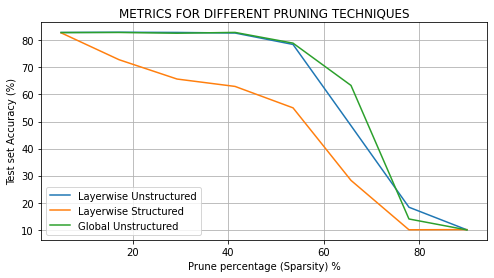

In [36]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(np.array(prunePercentages) * 100.0, np.array(l1_unstructured_accuracies), label='Layerwise Unstructured')
ax.plot(np.array(prunePercentages) * 100.0, np.array(l1_structured_accuracies), label='Layerwise Structured')
ax.plot(np.array(prunePercentages) * 100.0, np.array(global_prune_accuracies), label='Global Unstructured')
ax.set(xlabel ='Prune percentage (Sparsity) %', ylabel = 'Test set Accuracy (%)', title = 'METRICS FOR DIFFERENT PRUNING TECHNIQUES')
ax.legend()
ax.grid(True)
plt.show()

—— Observations

 - We can observe that even at ~55% Sparsity, layer wise unstructured pruning techniques maintain ~75% test accuracy.
 - Beyond a threshold (60% in our case), test accuracy drops significantly for all 3 techniques indicating the model is not able to capture enough information with the remaining weights
 - At least in our case, structured pruning is worse than unstructured pruning. 

### Model Metrics

#### Unstructured

In [37]:
model = MLPClassifier().to(device)
model.load_state_dict(torch.load("./MLP.pt"))
unStructuredPruneModel = layer_unstructured_prune(model, 0.3)

print_model_metrics(unStructuredPruneModel, random_input)

Model Size:  0.847 Mb
File Size:  0.892 Mb
Inference Time:  4e-05 s
Mega FLOPS:  0.443648
Mega MACs:  0.221824
Mega Params:  0.111146


#### Structured

In [38]:
model = MLPClassifier().to(device)
model.load_state_dict(torch.load("./MLP.pt"))
StructuredPruneModel = layer_structured_prune(model, 0.1)

print_model_metrics(StructuredPruneModel, random_input)

Model Size:  0.847 Mb
File Size:  0.892 Mb
Inference Time:  5e-05 s
Mega FLOPS:  0.443648
Mega MACs:  0.221824
Mega Params:  0.111146


### Global

In [39]:
model = MLPClassifier().to(device)
model.load_state_dict(torch.load("./MLP.pt"))
globalPruneModel = global_unstructured_prune(model, 0.9414)

print_model_metrics(globalPruneModel, random_input)

Model Size:  0.847 Mb
File Size:  0.892 Mb
Inference Time:  5e-05 s
Mega FLOPS:  0.443648
Mega MACs:  0.221824
Mega Params:  0.111146


**Now, let's plot all 4 layers of our custom model and see how different techiques have pruned weights**

In [40]:
import matplotlib
import matplotlib.patches as mpatches

binary_cmap = matplotlib.colors.ListedColormap(['#3D99FF', '#7F7F7F'])
patchList = []
for lab,c in zip([False, True], ['#3D99FF', '#7F7F7F']):
    patchList.append(mpatches.Patch(color=c, label=lab))

def plot_tensor_mask(pt_tensor, ax=None):
  z_np = pt_tensor.detach().cpu().numpy()
  ln = ax.imshow(z_np, cmap = binary_cmap)
  ax.axis('off')
  return ln

In [41]:
def plot_custom_model(model, title=''):
  fig, axes = plt.subplots(1,4,figsize=(16, 4), gridspec_kw={'width_ratios': [7,5,3,1]})

  model_masks = dict(model.named_buffers())
  plot_tensor_mask(model_masks['fc1.weight_mask'], axes[0])
  plot_tensor_mask(model_masks['fc2.weight_mask'], axes[1])
  plot_tensor_mask(model_masks['fc3.weight_mask'], axes[2])
  plot_tensor_mask(model_masks['fc4.weight_mask'], axes[3])
  
  axes[0].set_title('FC Layer1')
  axes[1].set_title('FC Layer2')
  axes[2].set_title('FC Layer3')
  axes[3].set_title('FC Layer4')
  
  if title is not '':
    plt.suptitle(title)

<>:15: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:15: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_150911/3520770426.py:15: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if title is not '':


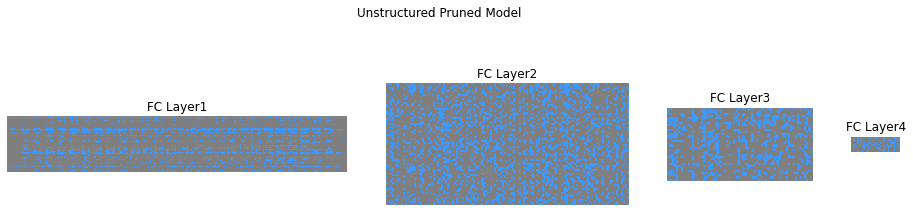

In [42]:
plot_custom_model(unStructuredPruneModel, title='Unstructured Pruned Model')

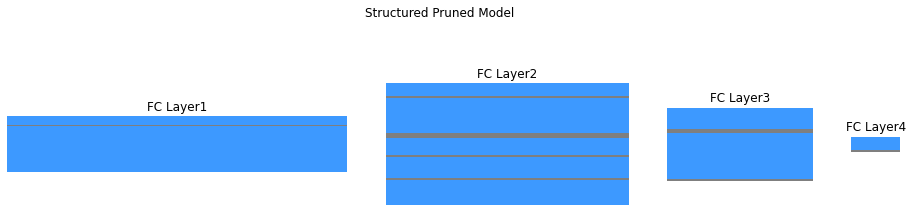

In [43]:
plot_custom_model(structuredPruneModel, title='Structured Pruned Model')

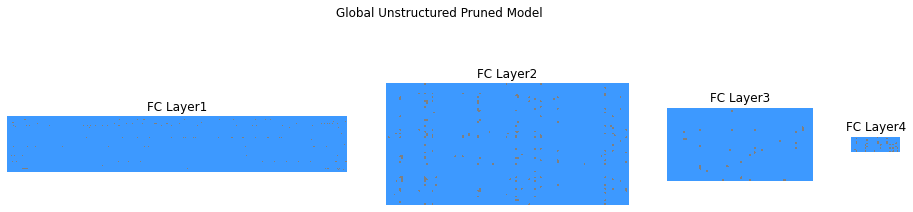

In [44]:
plot_custom_model(globalPruneModel, 'Global Unstructured Pruned Model')

### Notes —

Now that we pruned majority of our model, what performance improvement can we expect?

- For now, ***Pytorch pruning doesn't improve the runtime performance of the model. This is because, even though large percentage of weights can be set to zero, the forward pass still uses operations on the entire dense tensors of the model***
- ***Sparse tensor operations functionality is still very limited in Pytorch, but it has plans to incorporate optimizations to see effects of Pruning in production systems***
- To truly see the effect of the different pruning methods, we need to use a separate library that can optimize the model for pruned weights and apply it to production or recreate the pruned model structure from scratch